In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import utilities as ut


fitting_function = ut.multi_pV
plt.style.use('bmh')

### Your data

<details><summary>Here, we'll create some artificial data:</summary>

<div class="alert alert-block alert-info">
    You should replace the block which follows by loading your own data
    in form of x and y as numpy arrays of shape ("length of data", )<br>
    For example: <br>
    <pre>>>> x, y = np.loadtxt("your_file_containing_data.txt")</pre>
</div>
</details>

In [12]:
dummy_params = [51, 200, 85, 0.3,
                10, 272, 37, 0.8,
                2.7, 317, 39, 0.52,
                3.9, 471, 62, 0.25]

x = np.arange(0, 584, 1.34)
y = fitting_function(x, *dummy_params)  # Here it's the multi_pV function
# Add some noise to the data:
y += np.random.random(len(x)) * np.mean(y)/5

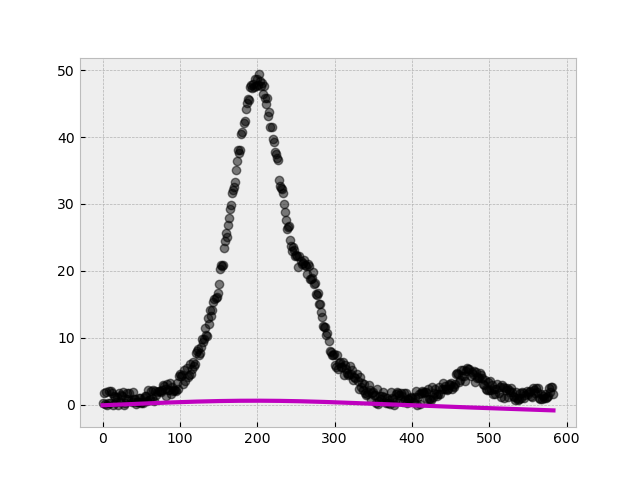

In [17]:
# Calculate the baseline using the default parameters:
bl = ut.baseline_als(y)

# Check the result visually:
plt.figure()
plt.plot(x, y, 'ok', alpha=.5)
plt.plot(x, bl, '-m', lw=3)
plt.show()

# Remove the baseline from the `y`:
y -= bl

### The funny part:  
provide your initial parameters for the fit

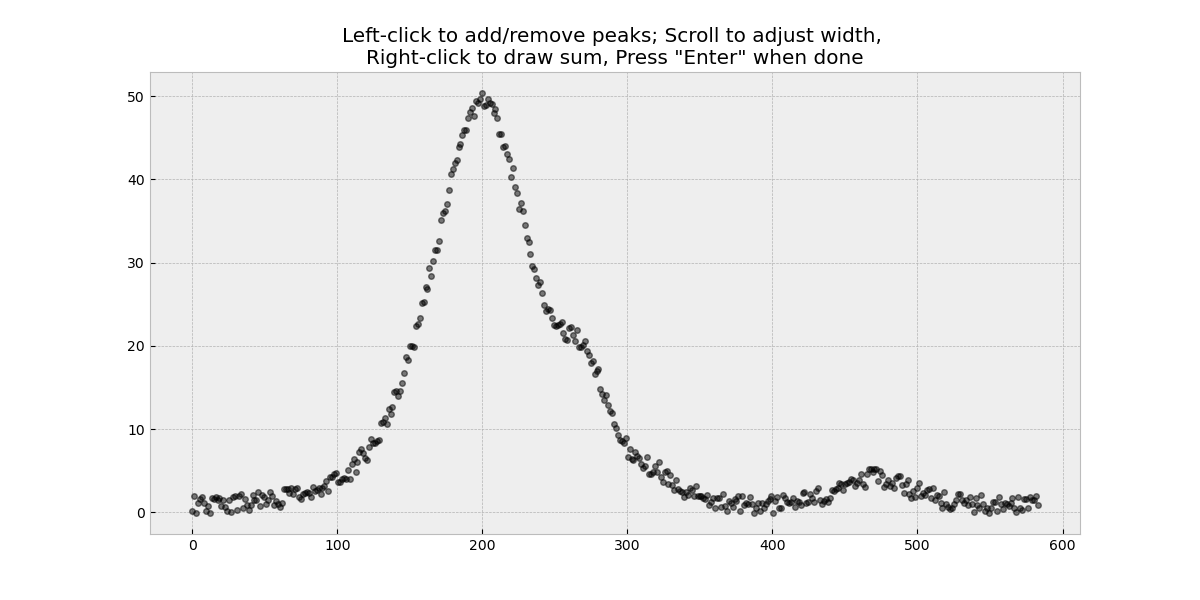

In [9]:
# check the docstring for the fitonclick class:
figsize=(12, 6)
mfit = ut.fitonclick(x, y, scrolling_speed=4, figsize=figsize)

In [4]:
# completely dull part, don't worry about it (still have to run it tough)
x_size = mfit.x_size
peaks_present: int = mfit.peak_counter
pic = mfit.pic

mf_params = mfit.manualfit_params

# check the sum of manually created peaks:
if len(mfit.sum_peak) == 1:  # if the sum is already drawn:
    manualfit = mfit.sum_peak[0][0].get_ydata()
else:  # redraw the sum of manually created peaks:
    manualfit = fitting_function(x, *mf_params)

# Setting the bounds relative on your input parameters
# (you can play with this part if you feel like it,
# but leaving it as it is should be ok for basic usage)
bounds = ut.set_bounds(mf_params.reshape(peaks_present, 4),
                       A=(0.5, 1.4, "multiply"),
                       x=(-2*x_size, 2*x_size, "add"),
                       w=(0.5, 16, "multiply"),
                       gl=(0, 1, "absolute"))

# The curve-fitting part that does all the real work:
fitted_params, b = curve_fit(fitting_function, x, y, method='trf',
                             p0=mf_params,
                             absolute_sigma=False, bounds=bounds)

# The results:
fitting_err = np.sqrt(np.diag(b))
y_fitted = fitting_function(x, *fitted_params)

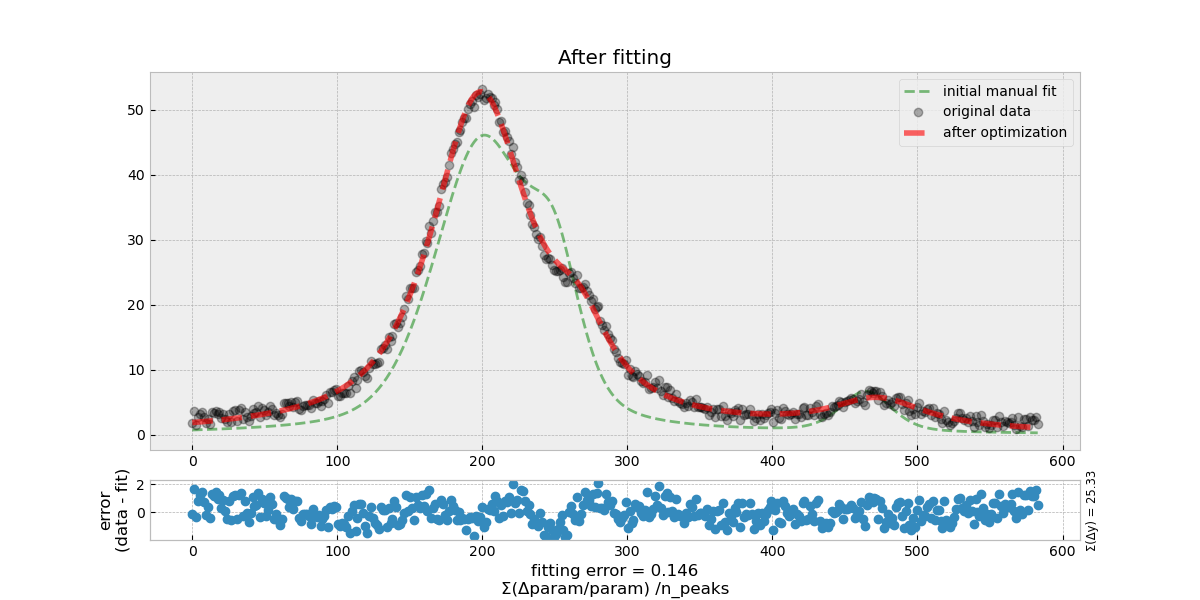

In [5]:
# Plotting the results of the optimization:
figg, axx, = plt.subplots(figsize=figsize)
figg.subplots_adjust(bottom=0.25)
errax = figg.add_axes([0.125, 0.1, 0.775, 0.1])
errax.set_facecolor('w')

axx.plot(x, manualfit,
         '--g', alpha=0.5, label='initial manual fit')

axx.plot(x, y, linestyle='none', marker='o', c='k',
         alpha=0.3, label='original data')

axx.plot(x, y_fitted,
         '--r', lw=4, alpha=0.6, label='after optimization')

axx.legend()

errax.plot(x, y - y_fitted, linestyle='none', marker='o')
errax.set_ylabel('error\n(data - fit)')
errax.set_xlabel(f'fitting error = '
                 f'{np.sum(fitting_err/np.ceil(fitted_params))/peaks_present:.3f}'
                 f'\n\u03A3(\u0394param/param) /n_peaks')
errax2 = errax.twinx()
errax2.set_yticks([])
errax2.set_ylabel(f'\u03A3(\u0394y) = {np.sum(y - y_fitted):.2f}',
                  fontsize='small')
axx.set_title('After fitting')
plt.show(block=False)


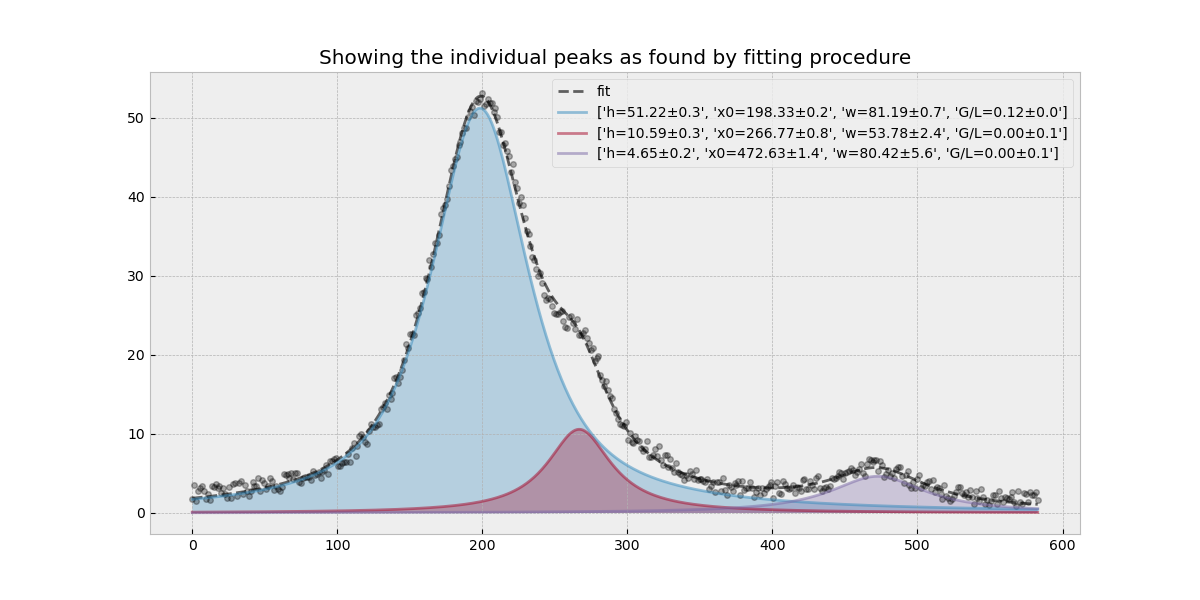

In [6]:
# Plotting the individual peaks after fitting
pfig, pax = plt.subplots(figsize=figsize)

pax.plot(x, y, linestyle='none', marker='o', ms=4, c='k', alpha=0.3)
pax.plot(x, y_fitted,
         '--k', lw=2, alpha=0.6, label='fit')
par_nam = ['h', 'x0', 'w', 'G/L']
for i in range(peaks_present):
    fit_res = list(zip(par_nam, fitted_params[i*4:i*4+4],
                       fitting_err[i*4:i*4+4]))
    label = [f"{P}={v:.2f}\U000000B1{e:.1f}" for P, v, e in fit_res]
    yy_i = ut.pV(x, *fitted_params[i*4:i*4+4])
    peak_i, = pax.plot(x, yy_i, alpha=0.5, label=label)
    pax.fill_between(x, yy_i, facecolor=peak_i.get_color(), alpha=0.3)
pax.legend()
pax.set_title('Showing the individual peaks as found by fitting procedure')

pfig.show()


In [8]:
# print the parameters as found by the fitting procedure:
parametar_names = ['Height', 'Center', 'FWMH', 'Gauss/Lorenz']
if len(dummy_params) == len(fitted_params):
    rpm = "Real params"
    real_parameter_values = [f"   ::   {dp:6.1f}" for dp in dummy_params]
else:
    rpm = ""
    real_parameter_values = [""]*peaks_present*4
print(f"{'Your initial guess':>30s}{'After fitting':>26s}{rpm:>16s}\n")
for i in range(len(fitted_params)):
    print(f"Peak {i//4}|   {parametar_names[i%4]:<13s}: "
          f" {mf_params[i]:8.2f}   ->   "
          f" {fitted_params[i]:6.2f} \U000000B1 {fitting_err[i]:4.2f}"
          f"{real_parameter_values[i]}")

            Your initial guess             After fitting                

Peak 0|   Height       :     44.69   ->     51.22 ± 0.27
Peak 0|   Center       :    199.79   ->    198.33 ± 0.21
Peak 0|   FWMH         :     78.28   ->     81.19 ± 0.65
Peak 0|   Gauss/Lorenz :      0.50   ->      0.12 ± 0.01
Peak 1|   Height       :     18.90   ->     10.59 ± 0.31
Peak 1|   Center       :    250.12   ->    266.77 ± 0.76
Peak 1|   FWMH         :     41.64   ->     53.78 ± 2.45
Peak 1|   Gauss/Lorenz :      0.50   ->      0.00 ± 0.09
Peak 2|   Height       :      6.24   ->      4.65 ± 0.18
Peak 2|   Center       :    464.53   ->    472.63 ± 1.40
Peak 2|   FWMH         :     41.64   ->     80.42 ± 5.60
Peak 2|   Gauss/Lorenz :      0.50   ->      0.00 ± 0.14


In [ ]:
# Deleting the class instance
del mfit